# Init

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [41]:
# constants
kb = 3.1668105e-06 # in hartree
ha2ev = 27.211386
kcalmol2ev = 0.043364104
kbev = kb*ha2ev # in eV
A3GPa2ev = 0.0062415091 # A^3*GPa in eV
ev2kjmol=96.485336

## The energy units in this notebook is in eV, unless specified otherwise

# 0K results

In [6]:
properties = {}

In [19]:
properties['Ih'] = {'natom': 1728,
                       'nfreedom': (1728-1)*3,
                       'U0': -21386.636 * kcalmol2ev, # in kcal/mol, # U at 0K in eV
                       'V0': 0, # volume at 0K in A^3 (doesn't matter as P=0)
                       'T0': 90, # the T for lambda integration
                       'eigval_T0': np.loadtxt("ipi-90K/phonon-90K/ih-90K.eigval"), # the eigenvalues of the phonon modes 
                       'dhdl_T0': np.loadtxt("ipi-90K/lambda-ti/dhdl.ih"), # dh/dl from har to ahar
                       'A2G_T0': [0.0636759, 0.000163532], # the rho correction term for A->G
                       'V_T0': 0, # the actual V used in the lambda integration (doesn't matter as P=0)
                       'press': 0, # GPa
                       'enthalpy_T': np.sort(np.loadtxt("lammps-npt/PE.list"), axis=0)[:,[0,1,2]] # enthalpy at different T in eV
                      }

In [31]:
properties['Ic'] = {'natom': 1728,
                       'nfreedom': (1728-1)*3,
                       'U0': -21386.636 * kcalmol2ev, # in kcal/mol, # U at 0K in eV
                       'V0': 0, # volume at 0K in A^3 (doesn't matter as P=0)
                       'T0': 90, # the T for lambda integration
                       'eigval_T0': np.loadtxt("ipi-90K/phonon-90K/ic-90K.eigval"), # the eigenvalues of the phonon modes 
                       'dhdl_T0': np.loadtxt("ipi-90K/lambda-ti/dhdl.ic"), # dh/dl from har to ahar
                       'A2G_T0': [0.0634221, 0.000165406], # the rho correction term for A->G
                       'V_T0': 0, # the actual V used in the lambda integration (doesn't matter as P=0)
                       'press': 0, # GPa
                       'enthalpy_T': np.sort(np.loadtxt("lammps-npt/PE.list"), axis=0)[:,[0,3,4]] # enthalpy at different T in eV
                      }

In [10]:
def get_G_0K(prop):
    return prop['U0']+A3GPa2ev*prop['V0']*prop['press']

def get_mu_0K(prop):
    return (prop['U0']+A3GPa2ev*prop['V0']*prop['press'])/prop['natom']

In [11]:
def get_har_T0(prop):
    T0 = prop['T0']
    return ha2ev*T0*kb*np.log(np.sqrt(prop['eigval_T0'][3:])/(T0*kb)).sum()

def get_ahar_T0(prop):
    T0 = prop['T0']
    dhdl = prop['dhdl_T0']
    it=0.0
    iterror=0.0
    for i in range(len(dhdl)-1):
        #print dhdl[i,0],dhdl[i,1]
        it += 0.5*(dhdl[i,1]+dhdl[i+1,1])*(dhdl[i+1,0]-dhdl[i,0])
        iterror += 0.5*(dhdl[i,2]**2.+dhdl[i,2]**2.)*(dhdl[i+1,0]-dhdl[i,0])
    return it, iterror

def get_A_T0(prop):
    Aharm_T0 = get_har_T0(prop)
    AanhT0, AanhT0error = get_ahar_T0(prop)
    AT0 = Aharm_T0+AanhT0
    #print(AT0, "+/-", AanhT0error)
    return AT0, AanhT0error

def get_G_T0(prop):
    AT0, AT0error  = get_A_T0(prop)
    GT0 = AT0 + prop['A2G_T0'][0] + A3GPa2ev*prop['V_T0']*prop['press']
    GT0error = AT0error + prop['A2G_T0'][1]  
    return GT0, GT0error

def get_mu_T0(prop):
    return np.asarray(get_G_T0(prop))/prop['natom']

In [21]:
def get_G(prop):
    
    G0 = get_G_0K(prop)
    T0 = prop['T0']
    nfree = prop['nfreedom']
    
    #print(prop['enthalpy_T'])
    ttnpt = prop['enthalpy_T'][:,0]
    ltnpt = np.log(ttnpt)
    #print ttnpt
    dhnow = np.zeros(len(ltnpt))
    dhnowerror = np.zeros(len(ltnpt))
    
    dhnow = prop['enthalpy_T'][:,1] * kcalmol2ev # unit conversion
    dhnowerror = prop['enthalpy_T'][:,2] * kcalmol2ev
    #print(dhnow)   
    # get delta H = H(t) - H(0) - n_free*kbt/2
    #for a in range(len(ttnpt)):
    #    print(dhnow[a], G0)
    #    dhnow[a] += c
        
    # integration
    intdhnow=np.zeros((len(ttnpt)-1,3))
    it=0.0
    iterror=0.0
    for i in range(len(ttnpt)-1):
        T1=ttnpt[i+1]
        it += 0.5*((dhnow[i]-G0-ttnpt[i]*kbev*nfree/2.)/ttnpt[i]+(dhnow[i+1]-G0- ttnpt[i+1]*kbev*nfree/2.)/ttnpt[i+1])*(ltnpt[i+1]-ltnpt[i])
        iterror += 0.5*((dhnowerror[i]/ttnpt[i])**2.+(dhnowerror[i+1]/ttnpt[i+1])**2.)*(ltnpt[i+1]-ltnpt[i])
        intdhnow[i,0]=T1
        intdhnow[i,1]=-it*T1
        intdhnow[i,2]=np.sqrt(iterror)*T1/np.sqrt(i+1)
    #print(intdhnow)
    
    G=np.zeros((len(ttnpt)+1,3))
    
    GT0, GT0error = get_G_T0(prop)
    G[0,:] = [0, G0,0]
    G[1,:]=[T0, GT0, GT0error]
    for i in range(len(ttnpt)-1):
        T1=intdhnow[i,0]
        if T1 >= T0:
            G[i+2,0]=T1
            G[i+2,1]=intdhnow[i,1]+G0+(T1/T0)*(GT0-G0)-prop['nfreedom']*kbev*T1*np.log(T1/T0)
            G[i+2,2]=intdhnow[i,2]+(T1/T0)*GT0error
    return G

def get_mu(prop):
    mu = get_G(prop)
    mu[:,[1,2]]/=prop['natom']
    return mu

In [29]:
get_G_T0(properties['Ih'])

(-906.6812277258687, 0.00016355695818119913)

In [32]:
get_G_T0(properties['Ic'])

(-906.6910726348056, 0.00016567539120976099)

In [35]:
get_G(properties['Ih'])

array([[ 0.00000000e+00, -9.27412308e+02,  0.00000000e+00],
       [ 9.00000000e+01, -9.06681228e+02,  1.63556958e-04],
       [ 1.05000000e+02, -9.10923708e+02,  1.63974900e-03],
       [ 1.20000000e+02, -9.15860157e+02,  1.46532536e-03],
       [ 1.35000000e+02, -9.21677265e+02,  1.45873277e-03],
       [ 1.50000000e+02, -9.28282214e+02,  1.49733699e-03],
       [ 1.65000000e+02, -9.35601243e+02,  1.55274607e-03],
       [ 1.80000000e+02, -9.43573755e+02,  1.61800379e-03],
       [ 1.95000000e+02, -9.52149370e+02,  1.68667279e-03],
       [ 2.10000000e+02, -9.61285698e+02,  1.75832453e-03],
       [ 2.25000000e+02, -9.70946307e+02,  1.83134215e-03],
       [ 2.40000000e+02, -9.81100342e+02,  1.90331488e-03],
       [ 2.55000000e+02, -9.91721111e+02,  1.97538618e-03],
       [ 2.70000000e+02, -1.00278552e+03,  2.04816358e-03],
       [ 2.85000000e+02, -1.01427413e+03,  2.12149579e-03]])

In [36]:
get_G(properties['Ic'])

array([[ 0.00000000e+00, -9.27412308e+02,  0.00000000e+00],
       [ 9.00000000e+01, -9.06691073e+02,  1.65675391e-04],
       [ 1.05000000e+02, -9.10930056e+02,  2.17860584e-03],
       [ 1.20000000e+02, -9.15866011e+02,  1.93972356e-03],
       [ 1.35000000e+02, -9.21681414e+02,  1.92735868e-03],
       [ 1.50000000e+02, -9.28283831e+02,  1.98430971e-03],
       [ 1.65000000e+02, -9.35598542e+02,  2.06646425e-03],
       [ 1.80000000e+02, -9.43564855e+02,  2.16088084e-03],
       [ 1.95000000e+02, -9.52132423e+02,  2.26088835e-03],
       [ 2.10000000e+02, -9.61258523e+02,  2.36337736e-03],
       [ 2.25000000e+02, -9.70907295e+02,  2.47067662e-03],
       [ 2.40000000e+02, -9.81046786e+02,  2.57823519e-03],
       [ 2.55000000e+02, -9.91650150e+02,  2.68094748e-03],
       [ 2.70000000e+02, -1.00269441e+03,  2.77910668e-03],
       [ 2.85000000e+02, -1.01416005e+03,  2.87868941e-03]])

In [37]:
mu_Ih = get_mu(properties['Ih'])
mu_Ic = get_mu(properties['Ic'])

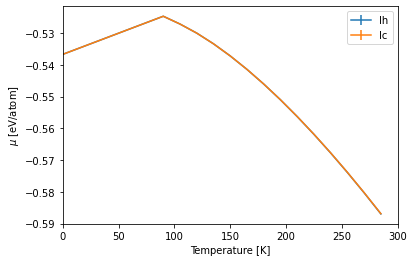

In [38]:
plt.errorbar(mu_Ih[:,0],mu_Ih[:,1],yerr=mu_Ih[:,2],label="Ih")
plt.errorbar(mu_Ic[:,0],mu_Ic[:,1],yerr=mu_Ic[:,2],label="Ic")
plt.xlim([0,300])
plt.xlabel("Temperature [K]")
plt.ylabel("$\mu$ [eV/atom]")
plt.legend()
plt.show()

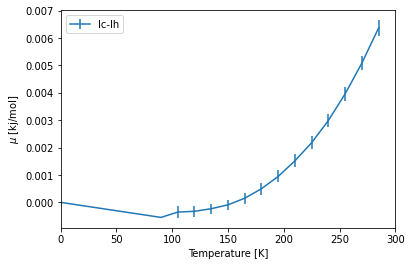

In [43]:
plt.errorbar(mu_Ic[:,0],ev2kjmol*(mu_Ic[:,1]-mu_Ih[:,1]),yerr=ev2kjmol*(mu_Ic[:,2]+mu_Ih[:,2]),label="Ic-Ih")
plt.xlim([0,300])
plt.xlabel("Temperature [K]")
plt.ylabel("$\mu$ [kj/mol]")
plt.legend()
plt.show()

# The free energy of the reference harmonic system with fixed mass at T0
### $A_\text{h}(T_0)=k_B T_0\sum_{i=1}^{3N-3}\ln(\dfrac{\hbar \omega_i}{k_B T_0})$

# Anharmonic correction of A at T0
### $A(V,T_0)-A_\text{h}(V,T_0)=\int_0^1 d \lambda \left<U-U_\text{h}\right>_{V,T_0,\lambda}$

# Transform the Helmholtz free energy to the Gibbs free energy
#### We used the isothermal-isobaric ensemble (NPT) in the simulations with zero external pressure, and allowed the 3 dimensions of the orthorhombic simulation cell are allowed to fluctuate independently. In this case we have
#### $G(P,T) = A (\textbf{h},T) + P \text{det}(\textbf{h}) + k_B T \ln \rho(\textbf{h}|P,T)$.
#### As $P=0$ in our case, so here we only need to compute $k_B T \ln \rho(\textbf{h}|P,T)$
#### For convinience, we used a bash script (processrhoxyz.sh) to compute this quantity.

# Thermodynamic Intergation at NPT
## $-T_1\int_{T_0}^{T_1} \dfrac{\left<\delta H\right>_{P,T}}{ T^2} dT=-T_1\int_{\ln T_0}^{\ln T_1} \left<\delta H\right>_{P,T}e^{-y} dy$

#### TI wrt T, starting at T_0=90K

## Now we put all the pieces together
## From the paper we have
###     $\dfrac{G(P,T_1)}{k_B T_1} = \dfrac{G(P,0)}{k_B T_1}+ \dfrac{G(P,T_0) - G(P,0)}{k_B T_0} -(3N-3) \ln(\dfrac{T_1}{T_0})- \int_{T_0}^{T_1} \dfrac{\left<\delta H\right>_{P,T}}{k_B T^2} dT.$
### so
### $G(P,T_1) = G(P,0)+ \dfrac{T_1}{T_0}(G(P,T_0) - G(P,0)) -(3N-3)k_B T_1 \ln(\dfrac{T_1}{T_0})-T_1\int_{\ln T_0}^{\ln T_1} \left<\delta H\right>_{P,T}e^{-y} dy$
### Note: These expressions are for systems with contrained center of mass

# Now compute the chemical potential dif
### $\mu = G_\text{Ic}/N_{Ic} - G_\text{Ih}/N{Ih}$